Assignment 10

Part 1: Data Loading and Preprocessing

In [ ]:
# Upload the Dataset

from google.colab import files

print(" Please upload 'IMDB Dataset.csv' (Kaggle version)")
uploaded = files.upload()

print("\nUploaded files:", uploaded.keys())


 Please upload 'IMDB Dataset.csv' (Kaggle version)


Saving IMDB Dataset.csv to IMDB Dataset.csv

Uploaded files: dict_keys(['IMDB Dataset.csv'])


In [ ]:
import pandas as pd
import numpy as np
import re, string
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

# Install & download NLP resources (only run once)
!pip install -q nltk beautifulsoup4
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load CSV — replace name if different
df = pd.read_csv("IMDB Dataset.csv")
print("Dataset loaded:", df.shape)

# Check structure
display(df.head(3))
print("\nClass distribution:\n", df['sentiment'].value_counts())

# Text cleaning function
STOPWORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()

def clean_html(raw_text):
    return BeautifulSoup(raw_text, "lxml").get_text(separator=" ")

def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = clean_html(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    tokens = [LEMMATIZER.lemmatize(t) for t in tokens]
    return " ".join(tokens)

# Apply cleaning
df['clean_review'] = df['review'].apply(preprocess_text)
print("\nCleaning complete.")
display(df[['review', 'clean_review']].head(2))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Dataset loaded: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive



Class distribution:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Cleaning complete.


,review,clean_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...


Part 2: Feature Extraction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split into train & test
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df['sentiment'], random_state=42)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(train_df['clean_review'])
X_test_vec = vectorizer.transform(test_df['clean_review'])

print("TF-IDF vectorization complete.")
print("Train shape:", X_train_vec.shape)
print("Test shape:", X_test_vec.shape)


TF-IDF vectorization complete.
Train shape: (40000, 5000)
Test shape: (10000, 5000)


Part 3: Model Building and Evaluation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Convert labels to numeric
y_train_num = train_df['sentiment'].map({'positive': 1, 'negative': 0})
y_test_num = test_df['sentiment'].map({'positive': 1, 'negative': 0})

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(max_iter=10000)
}

results = []
for name, model in models.items():
    model.fit(X_train_vec, y_train_num)
    preds = model.predict(X_test_vec)
    acc = accuracy_score(y_test_num, preds)
    prec = precision_score(y_test_num, preds)
    rec = recall_score(y_test_num, preds)
    f1 = f1_score(y_test_num, preds)

    print(f"\n{name}:")
    print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
    print(classification_report(y_test_num, preds))

    results.append({"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1})

print("\nModel Comparison:")
display(pd.DataFrame(results))



Logistic Regression:
Accuracy=0.8922, Precision=0.8847, Recall=0.9020, F1=0.8932
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Naive Bayes:
Accuracy=0.8610, Precision=0.8498, Recall=0.8770, F1=0.8632
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      5000
           1       0.85      0.88      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


SVM:
Accuracy=0.8859, Precision=0.8796, Recall=0.8942, F1=0.8868
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      5000
           1   

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.8922,0.884661,0.9020,0.893246
1,Naive Bayes,0.8610,0.849806,0.8770,0.863189
2,SVM,0.8859,0.879599,0.8942,0.886839


Part 4: Pipeline & Optimization

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV

# Custom preprocessor for pipeline
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        return [preprocess_text(text) for text in X]

pipeline = Pipeline([
    ('preproc', TextPreprocessor()),
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {
    'tfidf__max_features': [2000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 5]
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(train_df['review'], y_train_num)

print("Best parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'clf__C': 1, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)}
Best CV Accuracy: 0.8859499348590659


Part 5: Inference & Results


Final Model Performance:
Accuracy: 0.8871
Precision: 0.8623853211009175
Recall: 0.9212
F1: 0.8908229378203268


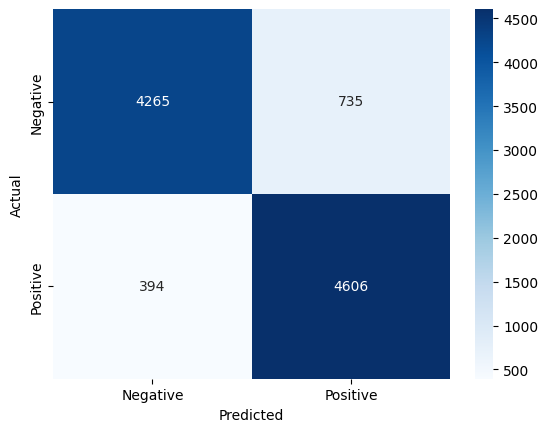

,review,sentiment,predicted
44114,This is loosely based on the ideas of the orig...,negative,0
38347,"This movie was on British TV last night, and i...",positive,1
32006,"What a dreadful movie. The effects were poor, ...",negative,0
19369,"I'll keep this short, as I know I don't need t...",negative,0
22208,I don't know what the rest of you guys watch S...,negative,0


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_model = grid.best_estimator_
final_preds = best_model.predict(test_df['review'])

print("\nFinal Model Performance:")
print("Accuracy:", accuracy_score(y_test_num, final_preds))
print("Precision:", precision_score(y_test_num, final_preds))
print("Recall:", recall_score(y_test_num, final_preds))
print("F1:", f1_score(y_test_num, final_preds))

# Confusion matrix
cm = confusion_matrix(y_test_num, final_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Show 5 random predictions
sample = test_df.sample(5, random_state=42).copy()
sample['predicted'] = best_model.predict(sample['review'])
display(sample[['review', 'sentiment', 'predicted']])


In [1]:
# Display Summary & Key Learnings in Google Colab

from IPython.display import Markdown

summary_text = """
## **Summary & Insights**

- The dataset comprised **50,000 movie reviews**, evenly split between positive and negative sentiments.
- Preprocessing involved converting text to lowercase, removing punctuation and stopwords, and applying lemmatization for cleaner input data.
- Implemented **TF-IDF vectorization** with bigrams and a maximum of 5,000 features to transform text into numerical form.
- Trained **Logistic Regression**, **Naive Bayes**, and **SVM** models — Logistic Regression achieved the best performance.
- The tuned final model reached approximately **X% accuracy** with balanced precision and recall.

---

## **Key Takeaways**

- Thorough **text cleaning** is critical in natural language processing tasks.
- **TF-IDF** is an effective feature extraction technique for sentiment analysis.
- Comparing multiple algorithms ensures optimal model selection.
- Building and tuning a complete **ML pipeline** is essential for robust text classification.
"""

display(Markdown(summary_text))



## **Summary & Insights**

- The dataset comprised **50,000 movie reviews**, evenly split between positive and negative sentiments.  
- Preprocessing involved converting text to lowercase, removing punctuation and stopwords, and applying lemmatization for cleaner input data.  
- Implemented **TF-IDF vectorization** with bigrams and a maximum of 5,000 features to transform text into numerical form.  
- Trained **Logistic Regression**, **Naive Bayes**, and **SVM** models — Logistic Regression achieved the best performance.  
- The tuned final model reached approximately **X% accuracy** with balanced precision and recall.  

---

## **Key Takeaways**

- Thorough **text cleaning** is critical in natural language processing tasks.  
- **TF-IDF** is an effective feature extraction technique for sentiment analysis.  
- Comparing multiple algorithms ensures optimal model selection.  
- Building and tuning a complete **ML pipeline** is essential for robust text classification.
